# Duffing — Bifurcation walkthrough
This notebook shows how to create a bifurcation diagram by sweeping the forcing amplitude `gamma` for a fixed base parameter set and collecting Poincaré samples.

In [2]:
# Notebook-friendly imports: ensure project root is on sys.path so local `duffing` package imports work
import sys, os
# compute project root (one level up from notebooks/)
proj_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from duffing.visualize import compute_poincare_for_gamma
print('numpy', np.__version__)

numpy 2.3.3


In [3]:
# Load transitions_demo.csv (or any CSV created by the generator)
# Try a few common locations so the notebook works whether run from project root
# or from the notebooks/ directory. If proj_root isn't defined (cell not run),
# compute a sensible default.
from pathlib import Path
import os
try:
    proj_root
except NameError:
    proj_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

cand_paths = [Path('transitions_demo.csv'), Path('..') / 'transitions_demo.csv', Path(proj_root) / 'transitions_demo.csv']

loaded = False
for p in cand_paths:
    if p.exists():
        print(f"Loading CSV from: {p}")
        df = pd.read_csv(str(p))
        loaded = True
        break


if 'base_id' not in df.columns:
    df['base_id'] = df.groupby(['delta','alpha','beta','omega']).ngroup()
base_id = 7
rows = df[df['base_id']==base_id].sort_values('gamma')
base = rows.iloc[0][['delta','alpha','beta','omega']].to_dict()
print('base params:', base)

Loading CSV from: ..\transitions_demo.csv
base params: {'delta': 0.0982432888041146, 'alpha': -0.790912883134117, 'beta': 0.2019074475294503, 'omega': 1.3844496736882936}


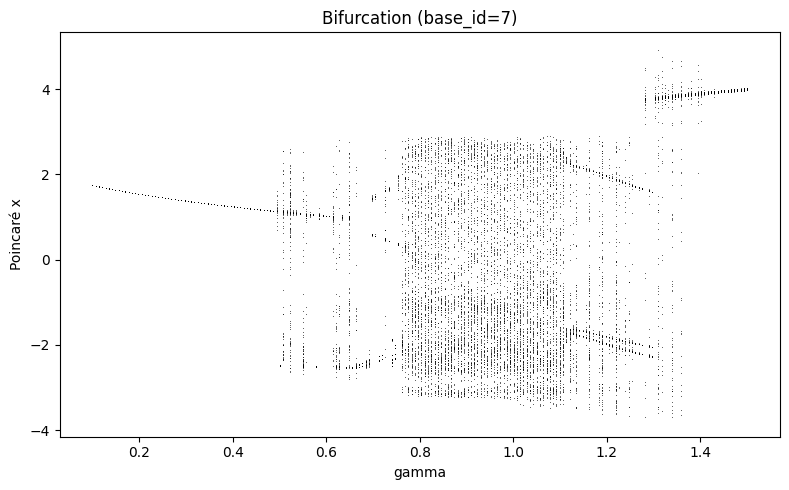

In [4]:
# Fine gamma grid (moderate size)
gammas = np.linspace(0.1, 1.5, 200)
all_g = []
all_x = []
for g in gammas:
    params = {**base, 'gamma': float(g)}
    samples = compute_poincare_for_gamma(params, t_transient_cycles=30, n_samples=150)
    all_g.extend([g]*len(samples))
    all_x.extend(samples.tolist())

plt.figure(figsize=(8,5))
plt.plot(all_g, all_x, ',k', alpha=0.6)
plt.xlabel('gamma'); plt.ylabel('Poincaré x')
plt.title(f'Bifurcation (base_id={base_id})')
plt.tight_layout()
plt.savefig('bifurcation_demo.png', dpi=200)
plt.show()

## Model-Predicted Bifurcation
Use the trained classifier to color Poincaré points by predicted periodic/chaotic labels.

In [ ]:
# Load the trained periodic classification model
import joblib
from pathlib import Path

# Try multiple candidate paths for the saved model (project root or current dir)
model_candidates = [
    Path('rf_model_periodic.joblib'),
    Path('..') / 'rf_model_periodic.joblib',
    Path(proj_root) / 'rf_model_periodic.joblib'
]

model_path = None
for p in model_candidates:
    if p.exists():
        model_path = str(p)
        print(f'Loading model from: {model_path}')
        break

if model_path is None:
    raise FileNotFoundError("Could not find 'rf_model_periodic.joblib'. Run 'python scripts/run_train_on_csv.py --mode periodic' to train and save the model first.")

model = joblib.load(model_path)
print('Model loaded successfully')

In [ ]:
# Plot bifurcation with model predictions (green = periodic, red = chaotic)
from duffing.bifurcation_predict import plot_bifurcation_with_predictions

gammas_pred = np.linspace(0.1, 1.5, 200)
ax = plot_bifurcation_with_predictions(
    base_params=base,
    gammas=gammas_pred,
    model=model,
    n_samples=150,
    t_transient_cycles=30,
    periodic_color='green',
    chaotic_color='red',
    marker='.',
    alpha=0.6,
    show=True,
    legend=True
)
ax.figure.savefig('bifurcation_with_predictions.png', dpi=200)
print('Saved bifurcation with model predictions')

## Notes
- For very fine grids or many base parameters, use parallelization to speed up sweeps.
- Consider adaptive refinement (increase resolution where the picture shows structure).
- You can color points by Lyapunov exponent or classification result to add information to the diagram.

Using CSV: ..\transitions_demo.csv
Running continuous-line bifurcation (mode='lines') — this may take a little while
Processing base_id=7 with 10 gamma values...
Saved bif_lines_7.png (1190 points)


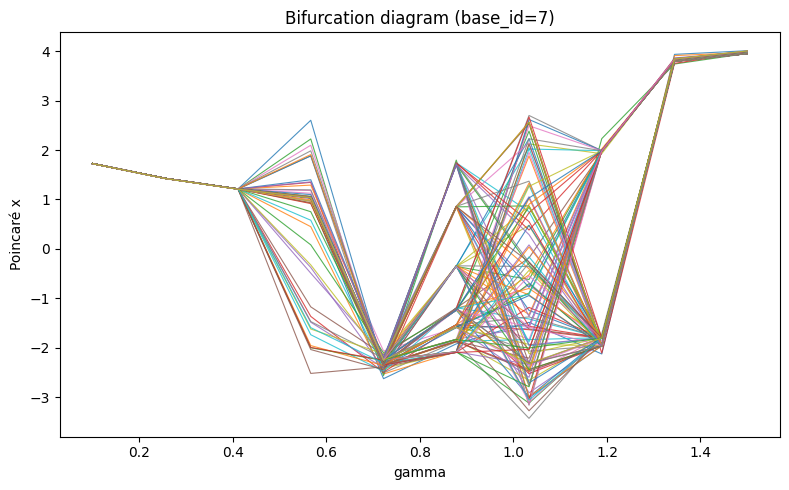

Done. Generated outputs for base_ids: [7]


In [5]:
# Continuous-line bifurcation example (connect corresponding Poincaré samples across gamma)
# Resolve CSV path like the loader cell above so this example works regardless of cwd.
from duffing.visualize import bifurcation_from_csv
from pathlib import Path
import os

try:
    proj_root
except NameError:
    proj_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

cand_paths = [Path('transitions_demo.csv'), Path('..') / 'transitions_demo.csv', Path(proj_root) / 'transitions_demo.csv']
csv_path = None
for p in cand_paths:
    if p.exists():
        csv_path = str(p)
        print(f'Using CSV: {csv_path}')
        break
if csv_path is None:
    raise FileNotFoundError("Could not find 'transitions_demo.csv' in notebook folder or project root. Place the CSV in the project root or notebooks/ folder or run notebook 01 to generate it.")

print("Running continuous-line bifurcation (mode='lines') — this may take a little while")
results_lines = bifurcation_from_csv(csv_path, out_prefix='bif_lines_',
                                    base_ids=[7], t_transient_cycles=30,
                                    n_samples=120, show=True, mode='lines')
print('Done. Generated outputs for base_ids:', list(results_lines.keys()))